<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "D1L-Fstl4"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/D1L-Fstl4/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


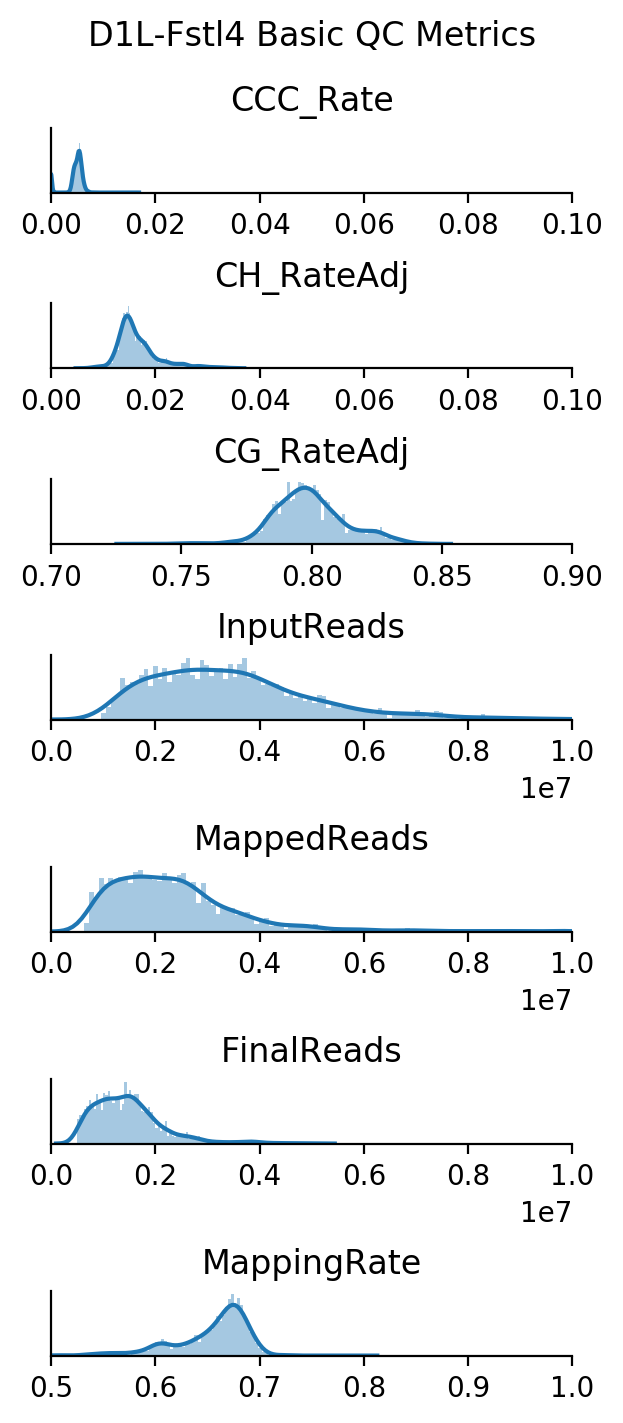

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

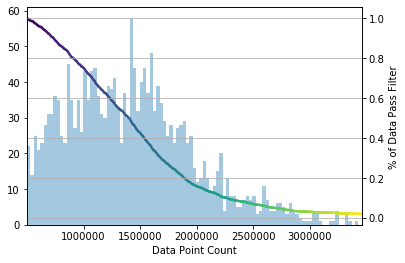

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1962/1962 (100.0%)
CG_RateAdj passed 1962/1962 (100.0%)
CH_RateAdj passed 1962/1962 (100.0%)
FinalReads passed 1962/1962 (100.0%)
MappingRate passed 1962/1962 (100.0%)
Overall passed 1962/1962 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 5
171219 3
180109 69
180110 201
180111 66
180220 63
180222 114
180313 31
180319 13
180320 66
180326 57
180329 184
180402 148
180403 125
180405 76
180724 17
180806 54
180911 133
180917 3
180925 1
181008 24
181009 19
181015 95
181016 103
181204 8
181206 2
181218 82
181220 199
190205 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 222 57.8%
ad002 263 68.5%
ad004 251 65.4%
ad006 268 69.8%
ad007 249 64.8%
ad008 246 64.1%
ad010 242 63.0%
ad012 221 57.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
2D_M_1020,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004500,0.807920,0.807050,0.019480,0.015050,1634755.0,3991682,2638762.0,2D,...,15.685232,-5.794035,16.964617,39.882972,D1L-Fstl4,5.305539,-20.450092,32.788790,11.881715,True
2D_M_105,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004340,0.805770,0.804920,0.018610,0.014330,560093.0,1162806,748402.0,2D,...,15.973783,-5.723970,17.715567,39.153335,D1L-Fstl4,4.500883,-20.976566,33.793099,9.166288,True
2D_M_1069,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004140,0.804040,0.803230,0.017310,0.013220,740636.0,1778264,1138163.0,2D,...,16.276516,-4.465415,16.544201,36.716837,D1L-Fstl4,3.150644,-20.224163,26.886549,4.511917,True
2D_M_1076,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.004710,0.805790,0.804870,0.019530,0.014890,1715336.0,4034150,2644737.0,2D,...,15.408726,-5.134717,15.412228,39.604679,D1L-Fstl4,4.825799,-19.346582,28.340525,12.705868,True
2D_M_1096,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.004590,0.801260,0.800340,0.019960,0.015440,759638.0,1583044,1052894.0,2D,...,15.908444,-5.453429,17.150334,38.779113,D1L-Fstl4,4.364199,-20.140207,29.052543,8.399272,True
2D_M_110,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004150,0.791260,0.790390,0.018580,0.014490,1241827.0,3133006,1887696.0,2D,...,15.273860,-4.443771,14.407499,38.737750,D1L-Fstl4,4.238040,-18.732489,24.687794,11.420368,True
2D_M_1123,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004520,0.798040,0.797120,0.017720,0.013260,1582869.0,3719118,2445237.0,2D,...,15.613920,-5.393251,16.177734,39.211852,D1L-Fstl4,4.914205,-19.554750,27.924107,11.379367,True
2D_M_115,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004180,0.806010,0.805200,0.018530,0.014410,1175626.0,2591116,1740875.0,2D,...,15.834751,-5.716999,17.171801,39.369709,D1L-Fstl4,5.248196,-20.773701,32.983060,10.644303,True
2D_M_1153,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.004240,0.775990,0.775040,0.013350,0.009150,3242163.0,7406528,4980869.0,2D,...,15.981874,-4.551167,15.483867,37.153732,D1L-Fstl4,3.503927,-19.457607,25.342354,6.360555,True
